##### · DWC: update how the truth is computed

In [19]:
import sys
import time
import numpy as np
import math
import pandas as pd
from sklearn.utils.validation import check_X_y
from honest_forests.estimators import HonestTreeClassifier
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_X_y
from sklearn.utils.multiclass import check_classification_targets
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import scipy.stats as stats

In [20]:
##Simulation Data 
#https://nbviewer.org/github/rflperry/math_tutorials/blob/master/tutorials/StatPatternRecognition/Trunk.ipynb

def simulate2(n, d):
    n1 = np.random.binomial(n, 0.5)
    n2 = n - n1
    mu = 1 / np.sqrt(np.arange(1, d+1))
    
    X = np.vstack((
        np.random.normal(mu, 1, (n1, d)),
        np.random.normal(-mu, 1,  (n2, d))
    ))
    
    return X, np.asarray([1]*n1 + [0]*n2)


In [21]:
def Posterior_After(X,v):
    
    #Duplicate the sigle sample test
    X_testsample_duplicated = np.tile(X,(X_structure.shape[0],1))
    
    ### Replace test data with values from structure subset   
    X_variable = X_structure[:,v]
    
    X_testsample_duplicated[:,v] = X_variable
    X_testsample_duplicated = X_testsample_duplicated.astype(np.float32)
    
    #Obtain the possible leaves with ignoring variable v
    leaves_indicies = np.unique(clf.tree_.apply(X_testsample_duplicated)) 
    value_leaves = np.sum(clf.tree_.value[leaves_indicies], axis=0)
    
    #Calculate the posterior probability for sample x
    
    posterior_proba = value_leaves/np.sum(value_leaves) 
    
    
    return value_leaves,posterior_proba

In [22]:
n = 1000
N = 100
d = 2
mu_1 = [1,1]
mu_2 = [-1,-1]
cov = np.arange(0,1,0.05)

#iteration speed is slow, decrese the iteration time from 100 to 10/20
n_repeat = 100

In [ ]:
ER_0 = np.zeros((N,len(cov)))
ER_1 = np.zeros((N,len(cov)))
for num in range(0,N):
    #print(num)
    ER_cov = np.zeros((1,2))
    for cov_i in cov:
        Sigma = [[1,cov_i],[cov_i,1]]
        X = np.vstack((np.random.multivariate_normal(mu_1,Sigma,n1),np.random.multivariate_normal(mu_2,Sigma,n2)))
        y_train = np.asarray([1]*n1 + [0]*n2)
        y_train_repeat = np.repeat(y_train,n_repeat)
        
        X_repeat = np.zeros((X.shape[0]*n_repeat,2))
        X_repeat[:,0] = np.repeat(X[:,0],n_repeat)
        X_repeat[:,1] = np.repeat(X[:,1],n_repeat)
        X_condition = X_repeat
        
        for i in range(0,n1):
            X_condition[i*n_repeat:i*n_repeat+n_repeat,0] = np.random.normal(mu_1[0]+cov_i*(X[i,1]-mu_1[1]),1-cov_i*1*cov_i,n_repeat)
            X_condition[i*n_repeat:i*n_repeat+n_repeat,1] = np.random.normal(mu_1[1]+cov_i*(X[i,0]-mu_1[0]),1-cov_i*1*cov_i,n_repeat)
        
        for i in range(n1,n1+n2):
            X_condition[i*n_repeat:i*n_repeat+n_repeat,0] = np.random.normal(mu_2[0]+cov_i*(X[i,1]-mu_2[1]),1-cov_i*1*cov_i,n_repeat)
            X_condition[i*n_repeat:i*n_repeat+n_repeat,1] = np.random.normal(mu_2[1]+cov_i*(X[i,0]-mu_2[0]),1-cov_i*1*cov_i,n_repeat)

        #print(X_condition.shape)
        clf_originDT =  DecisionTreeClassifier(max_depth = 5)
        clf_originDT = clf_originDT.fit(X, y_train)
        y_predict_originDT = clf_originDT.predict(X)
        error_origin = np.mean(np.abs(y_predict_originDT - y_train))
        #print(error_origin)
        error_clf2 = []
        
        
        for j in range(0,X_repeat.shape[1]):
            if j == 0:
                k = 1
            if j == 1:
                k = 0
            X_train = X_repeat
            X_train[:,k] = X_condition[:,k]
            #print(X_train.shape)
            y_predict = clf_originDT.predict(X_train)
            error_clf2 = np.append(error_clf2,np.mean(np.abs(y_predict - y_train_repeat))-error_origin)
        ER_cov = np.vstack((ER_cov,error_clf2))
    
    ER_0[num,:] = ER_cov[1:,0]
    ER_1[num,:] = ER_cov[1:,1]

average width of 95% CI of DT True-FIM Score is 0.004350015977778112


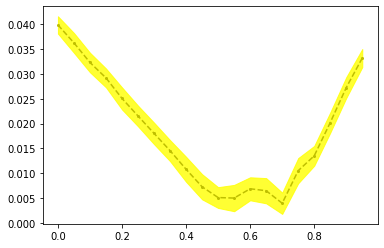

In [6]:
score_Ture2_mean = np.mean(ER_1,axis = 0)
ci_Ture2_low,ci_Ture2_up = stats.t.interval(0.95, N-1, loc=np.mean(ER_1,axis = 0), scale=stats.sem(ER_1,axis = 0))
plt.plot(cov,score_Ture2_mean,'y--',marker='o', markersize=2,label = 'Mean DT True-FIM Score')
plt.fill_between(cov,ci_Ture2_low,ci_Ture2_up,alpha = 0.8,color = 'yellow',label = '95% CI of DT True-FIM Score')
width_Ture2 = np.mean(ci_Ture2_up-ci_Ture2_low)
print("average width of 95% CI of DT True-FIM Score is " + str(width_Ture2))

In [23]:
##Compute the true importance
ER_HT0 = np.zeros((N,len(cov)))
ER_HT1 = np.zeros((N,len(cov)))
for num in range(0,N):
    n1 = np.random.binomial(n, 0.5)
    n2 = n-n1
    #print(num)
    ER_HTcov = np.zeros((1,2))
    for cov_i in cov:
        Sigma = [[1,cov_i],[cov_i,1]]
        X_train = np.vstack((np.random.multivariate_normal(mu_1,Sigma,n1),np.random.multivariate_normal(mu_2,Sigma,n2)))
        y_train = np.asarray([1]*n1 + [0]*n2)
        
        
        
        X = np.vstack((np.random.multivariate_normal(mu_1,Sigma,n1),np.random.multivariate_normal(mu_2,Sigma,n2)))
        y_test = np.asarray([1]*n1 + [0]*n2)
        y_test_repeat = np.repeat(y_train,n_repeat)
        
        X_repeat = np.zeros((X.shape[0]*n_repeat,2))
        X_repeat[:,0] = np.repeat(X[:,0],n_repeat)
        X_repeat[:,1] = np.repeat(X[:,1],n_repeat)
        X_condition = np.zeros((X.shape[0]*n_repeat,2))
        ##resample for target feature
        for k in range(0,2):
            X_condition[:,k] = X_repeat[:,k]
        
        for i in range(0,n1):
            X_condition[i*n_repeat:i*n_repeat+n_repeat,0] = np.random.normal(mu_1[0]+cov_i*(X[i,1]-mu_1[1]),1-cov_i*1*cov_i,n_repeat)
            X_condition[i*n_repeat:i*n_repeat+n_repeat,1] = np.random.normal(mu_1[1]+cov_i*(X[i,0]-mu_1[0]),1-cov_i*1*cov_i,n_repeat)
        
        for i in range(n1,n1+n2):
            X_condition[i*n_repeat:i*n_repeat+n_repeat,0] = np.random.normal(mu_2[0]+cov_i*(X[i,1]-mu_2[1]),1-cov_i*1*cov_i,n_repeat)
            X_condition[i*n_repeat:i*n_repeat+n_repeat,1] = np.random.normal(mu_2[1]+cov_i*(X[i,0]-mu_2[0]),1-cov_i*1*cov_i,n_repeat)

        #print(X_condition.shape)
        clf_originHT =  HonestTreeClassifier(honest_fraction = 0.3)
        clf_originHT = clf_originHT.fit(X_train, y_train)
        y_predict_originHT = clf_originHT.predict(X)
        error_origin = np.mean(np.abs(y_predict_originHT - y_test))
        #print(error_origin)
        error_clf = []
        
        
        for j in range(0,X_repeat.shape[1]):
            X_test_repeat = np.zeros((X.shape[0]*n_repeat,2))
            for k in range(0,2):
                X_test_repeat[:,k] = X_repeat[:,k]
            X_test_repeat[:,j] = X_condition[:,j]
            #print(X_train.shape)
            y_predict = clf_originHT.predict(X_test_repeat)
            error_condition = np.mean(np.abs(y_predict - y_test_repeat))
            error_clf = np.append(error_clf,error_condition - error_origin)
        ER_HTcov = np.vstack((ER_HTcov,error_clf))
        #print(ER_HTcov.shape)
    
    ER_HT0[num,:] = ER_HTcov[1:,0]
    ER_HT1[num,:] = ER_HTcov[1:,1]

average width of 95% CI of HT True-FIM Score is 0.003971772388829456


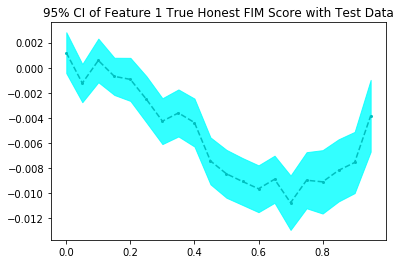

In [24]:
score_Ture_mean = np.mean(ER_HT0,axis = 0)
ci_Ture_low,ci_Ture_up = stats.t.interval(0.95, N-1, loc=np.mean(ER_HT0,axis = 0), scale=stats.sem(ER_HT0,axis = 0))
plt.plot(cov,score_Ture_mean,'c--',marker='o', markersize=2,label = 'Mean HT True-FIM Score')
plt.fill_between(cov,ci_Ture_low,ci_Ture_up,alpha = 0.8,color = 'cyan',label = '95% CI of HT True-FIM Score')
width_Ture = np.mean(ci_Ture_up-ci_Ture_low)
plt.title('95% CI of Feature 1 True Honest FIM Score with Test Data')
print("average width of 95% CI of HT True-FIM Score is " + str(width_Ture))



average width of 95% CI of HT True-FIM Score is 0.003945323407432447


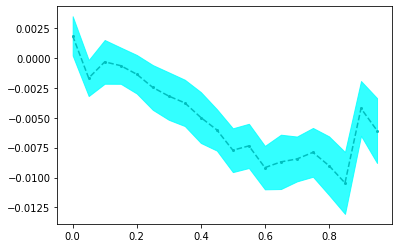

In [25]:
score_Ture_mean = np.mean(ER_HT1,axis = 0)
ci_Ture_low,ci_Ture_up = stats.t.interval(0.95, N-1, loc=np.mean(ER_HT1,axis = 0), scale=stats.sem(ER_HT1,axis = 0))
plt.plot(cov,score_Ture_mean,'c--',marker='o', markersize=2,label = 'Mean HT True-FIM Score')
plt.fill_between(cov,ci_Ture_low,ci_Ture_up,alpha = 0.8,color = 'cyan',label = '95% CI of HT True-FIM Score')
width_Ture = np.mean(ci_Ture_up-ci_Ture_low)
print("average width of 95% CI of HT True-FIM Score is " + str(width_Ture))

In [26]:
np.sum(ER_HT1-ER_HT0)

0.6320099999999996

In [27]:
##Compute feature importance from FIMs
score_ht_0 = np.zeros((N,len(cov))) ## HFIM
score_htp_0 = np.zeros((N,len(cov))) ## Permutation FIM with honest tree
# score_dtp_0 = np.zeros((N,len(cov)))## Permutation FIM with Decision tree

score_ht_1 = np.zeros((N,len(cov)))
score_htp_1 = np.zeros((N,len(cov)))
# score_dtp_1 = np.zeros((N,len(cov)))


#print(variance_diff_cov)
for num in range(0,N):
    #print(num)
    mean_diff_cov = np.zeros((1,2)) 
    score_htp_cov = np.zeros((1,2))
    # score_dt_cov = np.zeros((1,2))
    for cov_i in cov:
        Sigma = [[1,cov_i],[cov_i,1]]
        X_train = np.vstack((np.random.multivariate_normal(mu_1,Sigma ,n1),np.random.multivariate_normal(mu_2,Sigma,n2)))
        y_train = np.asarray([1]*n1 + [0]*n2)
        #X_test = np.vstack((np.random.multivariate_normal(mu_1,Sigma ,n_test),np.random.multivariate_normal(mu_2,Sigma,n_test)))
        #y_test = np.asarray([1]*n_test + [0]*n_test)
        
    
        clf = HonestTreeClassifier(honest_fraction = 0.8)
        clf = clf.fit(X_train, y_train)
    
        X_structure = X_train[clf.structure_indices_]
        X_honest = X_train[clf.honest_indices_]
        y_honest = y_train[clf.honest_indices_]
    
        leaves_indicies_before = clf.tree_.apply(X_honest.astype(np.float32))
        value_leaves_before = clf.tree_.value[leaves_indicies_before]
        classification_before = np.zeros(X_honest.shape[0])
    
        posterior_proba_before = np.zeros((X_honest.shape[0],2))##n_classes
        value_leaves = np.zeros((X_honest.shape[0],2))
        posterior_proba = np.zeros((X_honest.shape[0],2))
    
        classification_after = np.zeros(X_honest.shape[0])
        difference_clf = np.zeros(X_honest.shape[0])
    
    
    
        mean_diff = []
        for k in range(0,X_honest.shape[1]):
            for i in range(0,X_honest.shape[0]):
                ##Compute posterior probability before merging
                posterior_proba_before[i,:] = value_leaves_before[i,:]/np.sum(value_leaves_before[i,:])
                ##Compute posterior probability after merging
                value_leaves[i,:],posterior_proba[i,:] = Posterior_After(X_honest[i,:],k)
            
            
            ## Get the classification_before result
            classification_before = posterior_proba_before.argmax(1)
            #print(classification_before)

            ## Get the classification_after result
            classification_after = posterior_proba.argmax(1)
        
            #Calculate classification error before 
            error_before = np.mean(np.abs(y_honest - classification_before))
        
            #Calculate classification error after merging leaves
            error_after = np.mean(np.abs(y_honest - classification_after))
            #Calculate the difference of classification error
            difference_clf = error_after - error_before
            mean_diff = np.append(mean_diff,difference_clf)
        mean_diff_cov = np.vstack((mean_diff_cov,mean_diff))
        
        #Calculter Permutation Based HT socre
        r_htp = permutation_importance(clf, X_train, y_train,n_repeats=5)
        score_htp_cov = np.vstack((score_htp_cov,r_htp.importances_mean))
        
        #Calculter Permutation Based DT socre
#         clfDT = DecisionTreeClassifier(max_depth = 5)
#         clfDT = clfDT.fit(X_train, y_train)
#         r_dt = permutation_importance(clfDT, X_train, y_train,n_repeats=5)
#         score_dt_cov = np.vstack((score_dt_cov,r_dt.importances_mean))
        
        
        
    mean_diff_cov = mean_diff_cov[1:,:]
    score_htp_cov = score_htp_cov[1:,:]
#     score_dtp_cov = score_dt_cov[1:,:]
    
    score_ht_0[num,:] = mean_diff_cov[:,0]
    score_htp_0[num,:] = score_htp_cov[:,0]
#     score_dtp_0[num,:] = score_dtp_cov[:,0]
    
    score_ht_1[num,:] = mean_diff_cov[:,1]
    score_htp_1[num,:] = score_htp_cov[:,1]
#     score_dtp_1[num,:] = score_dtp_cov[:,1]
    

average width of 95% CI of HT True-FIM Score is 0.0033807559584829406
average width of 95% CI of Feature 1 HT-FIM Score is 0.021720993520579986
average width of 95% CI of Permutation Based Feature 1 FIM Score HT is 0.02776992683998339


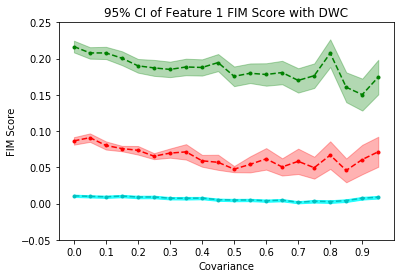

In [121]:
#Calculate 95% CI of HT socre around 100 times iterations

score_Ture_mean = np.mean(ER_HT0,axis = 0)
ci_Ture_low,ci_Ture_up = stats.t.interval(0.95, N-1, loc=np.mean(ER_HT0,axis = 0), scale=stats.sem(ER_HT0,axis = 0))
plt.plot(cov,score_Ture_mean,'c--',marker='o', markersize=3,label = 'Mean HT True-FIM Score')
plt.fill_between(cov,ci_Ture_low,ci_Ture_up,alpha = 0.8,color = 'cyan',label = '95% CI of HT True-FIM Score')
width_Ture = np.mean(ci_Ture_up-ci_Ture_low)
print("average width of 95% CI of HT True-FIM Score is " + str(width_Ture))


# score_Ture2_mean = np.mean(ER_0,axis = 0)
# ci_Ture2_low,ci_Ture2_up = stats.t.interval(0.95, N-1, loc=np.mean(ER_0,axis = 0), scale=stats.sem(ER_0,axis = 0))
# plt.plot(cov,score_Ture2_mean,'y--',marker='o', markersize=3,label = 'Mean DT True-FIM Score')
# plt.fill_between(cov,ci_Ture2_low,ci_Ture2_up,alpha = 0.8,color = 'yellow',label = '95% CI of DT True-FIM Score')
# width_Ture2 = np.mean(ci_Ture2_up-ci_Ture2_low)
# print("average width of 95% CI of DT True-FIM Score is " + str(width_Ture2))

score_ht_mean = np.mean(score_ht_0,axis = 0)
ci_ht_low,ci_ht_up = stats.t.interval(0.95, N-1, loc=np.mean(score_ht_0,axis = 0), scale=stats.sem(score_ht_0,axis = 0))
plt.plot(cov,score_ht_mean,'r--',marker='o', markersize=3,label = 'Mean Feature 1 HT-FIM Score')
plt.fill_between(cov,ci_ht_low,ci_ht_up,alpha = 0.3,color = 'red',label = '95% CI of HT-FIM Score')
width_ht = np.mean(ci_ht_up-ci_ht_low)
print("average width of 95% CI of Feature 1 HT-FIM Score is " + str(width_ht))

#Calculate 95% CI of Permutation Based HT socre around 50 times iterations
score_htp_mean = np.mean(score_htp_0,axis = 0)
ci_htp_low,ci_htp_up = stats.t.interval(0.95, N-1, loc=np.mean(score_htp_0,axis = 0), scale=stats.sem(score_htp_0,axis = 0))
plt.plot(cov,score_htp_mean,'g--',marker='o', markersize=3,label = 'Mean Feature 1 FIM Score of Permutation Based HT')
plt.fill_between(cov,ci_htp_low,ci_htp_up,alpha = 0.3,color ='green',label = '95% CI of Permutation Based HT Score')
width_htp = np.mean(ci_htp_up-ci_htp_low)
print("average width of 95% CI of Permutation Based Feature 1 FIM Score HT is "+str(width_htp))


# #Calculate 95% CI of Permutation Based DT socre around 50 times iterations
# score_dtp_mean = np.mean(score_dtp_0,axis = 0)
# ci_dtp_low,ci_dtp_up = stats.t.interval(0.95, N-1, loc=np.mean(score_dtp_0,axis = 0), scale=stats.sem(score_dtp_0,axis = 0))
# plt.plot(cov,score_dtp_mean,'b--',marker='o', markersize=3,label = 'Mean Feature 1 FIM Score of Permutation Based DT')
# plt.fill_between(cov,ci_dtp_low,ci_dtp_up,alpha = 0.3,color ='blue',label = '95% CI of Permutation Based DT Score')
# width_dtp = np.mean(ci_dtp_up-ci_dtp_low)
# print("average width of 95% CI of Permutation Based Feature 1 FIM Score DT is " +str(width_dtp))

# #Calculate the real importance score



plt.xticks(np.arange(0,1,0.1))
plt.yticks(np.arange(-0.05, 0.3, 0.05))
plt.xlabel('Covariance')
plt.ylabel('FIM Score')
#plt.legend(loc = 'upper right',fontsize = 'medium')
plt.title('95% CI of Feature 1 FIM Score with DWC')
plt.savefig('95% Confidential Interval of Feature 1 FIM Score with Relevant Data')
plt.show()

average width of 95% CI of HT True-FIM Score is 0.0034824947203523277
average width of 95% CI of Feature 2 HT-FIM Score is 0.024059545916022156
average width of 95% CI of Permutation Based Feature 2 FIM Score HT is 0.027899480733250836


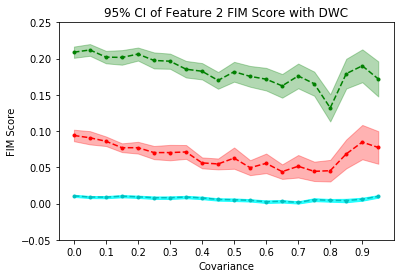

In [122]:
#Calculate 95% CI of HT socre around 100 times iterations


score_Ture_mean = np.mean(ER_HT1,axis = 0)
ci_Ture_low,ci_Ture_up = stats.t.interval(0.95, N-1, loc=np.mean(ER_HT1,axis = 0), scale=stats.sem(ER_HT1,axis = 0))
plt.plot(cov,score_Ture_mean,'c--',marker='o', markersize=3,label = 'Mean HT True-FIM Score')
plt.fill_between(cov,ci_Ture_low,ci_Ture_up,alpha = 0.8,color = 'cyan',label = '95% CI of HT True-FIM Score')
width_Ture = np.mean(ci_Ture_up-ci_Ture_low)
print("average width of 95% CI of HT True-FIM Score is " + str(width_Ture))


# score_Ture2_mean = np.mean(ER_1,axis = 0)
# ci_Ture2_low,ci_Ture2_up = stats.t.interval(0.95, N-1, loc=np.mean(ER_1,axis = 0), scale=stats.sem(ER_1,axis = 0))
# plt.plot(cov,score_Ture2_mean,'y--',marker='o', markersize=3,label = 'Mean DT True-FIM Score')
# plt.fill_between(cov,ci_Ture2_low,ci_Ture2_up,alpha = 0.8,color = 'yellow',label = '95% CI of DT True-FIM Score')
# width_Ture2 = np.mean(ci_Ture2_up-ci_Ture2_low)
# print("average width of 95% CI of DT True-FIM Score is " + str(width_Ture2))


score_ht_mean = np.mean(score_ht_1,axis = 0)
ci_ht_low,ci_ht_up = stats.t.interval(0.95, N-1, loc=np.mean(score_ht_1,axis = 0), scale=stats.sem(score_ht_1,axis = 0))
plt.plot(cov,score_ht_mean,'r--',marker='o', markersize=3,label = 'Mean Feature 2 HT-FIM Score')
plt.fill_between(cov,ci_ht_low,ci_ht_up,alpha = 0.3,color = 'red',label = '95% CI of HT-FIM Score')
width_ht = np.mean(ci_ht_up-ci_ht_low)
print("average width of 95% CI of Feature 2 HT-FIM Score is " + str(width_ht))

#Calculate 95% CI of Permutation Based HT socre around 50 times iterations
score_htp_mean = np.mean(score_htp_1,axis = 0)
ci_htp_low,ci_htp_up = stats.t.interval(0.95, N-1, loc=np.mean(score_htp_1,axis = 0), scale=stats.sem(score_htp_1,axis = 0))
plt.plot(cov,score_htp_mean,'g--',marker='o', markersize=3,label = 'Mean Feature 2 FIM Score of Permutation Based HT')
plt.fill_between(cov,ci_htp_low,ci_htp_up,alpha = 0.3,color ='green',label = '95% CI of Permutation Based HT Score')
width_htp = np.mean(ci_htp_up-ci_htp_low)
print("average width of 95% CI of Permutation Based Feature 2 FIM Score HT is "+str(width_htp))


# #Calculate 95% CI of Permutation Based DT socre around 50 times iterations
# score_dtp_mean = np.mean(score_dtp_1,axis = 0)
# ci_dtp_low,ci_dtp_up = stats.t.interval(0.95, N-1, loc=np.mean(score_dtp_1,axis = 0), scale=stats.sem(score_dtp_1,axis = 0))
# plt.plot(cov,score_dtp_mean,'b--',marker='o', markersize=3,label = 'Mean Feature 2 FIM Score of Permutation Based DT')
# plt.fill_between(cov,ci_dtp_low,ci_dtp_up,alpha = 0.3,color ='blue',label = '95% CI of Permutation Based DT Score')
# width_dtp = np.mean(ci_dtp_up-ci_dtp_low)
# print("average width of 95% CI of Permutation Based Feature 2 FIM Score DT is " +str(width_dtp))

#Calculate the real importance score



plt.xticks(np.arange(0,1,0.1))
plt.yticks(np.arange(-0.05, 0.3, 0.05))
plt.xlabel('Covariance')
plt.ylabel('FIM Score')
#plt.legend(loc = 'upper right',fontsize = 'x-small')
plt.title('95% CI of Feature 2 FIM Score with DWC')
plt.savefig('95% Confidential Interval of Feature 2 FIM Score with Relevant Data')
plt.show()